## 匯入openCv
* 版本打印 `print(cv2.__version__)`
* 讀取yolo v3 tiny模型


In [100]:
import cv2

In [101]:
print(cv2.__version__)

4.3.0


In [102]:
net = cv2.dnn.readNetFromDarknet("yolov3_tiny.cfg", "yolov3-tiny.weights")

In [103]:
layer_names = net.getLayerNames()
print(layer_names)

['conv_0', 'bn_0', 'relu_1', 'pool_1', 'conv_2', 'bn_2', 'relu_3', 'pool_3', 'conv_4', 'bn_4', 'relu_5', 'pool_5', 'conv_6', 'bn_6', 'relu_7', 'pool_7', 'conv_8', 'bn_8', 'relu_9', 'pool_9', 'conv_10', 'bn_10', 'relu_11', 'pool_11', 'conv_12', 'bn_12', 'relu_13', 'conv_13', 'bn_13', 'relu_14', 'conv_14', 'bn_14', 'relu_15', 'conv_15', 'permute_16', 'yolo_16', 'identity_17', 'conv_18', 'bn_18', 'relu_19', 'upsample_19', 'concat_20', 'conv_21', 'bn_21', 'relu_22', 'conv_22', 'permute_23', 'yolo_23']


In [112]:
output_layers = [layer_names[i[0]-1] for i in net.getUnconnectedOutLayers()] 

output_layers = ['yolo_16', 'yolo_23']
print(output_layers)

['yolo_16', 'yolo_23']


In [113]:
classes = [line.strip() for line in open("yolov3_tiny.names")]
print(classes)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


影像的維度大小： (183, 275, 3)


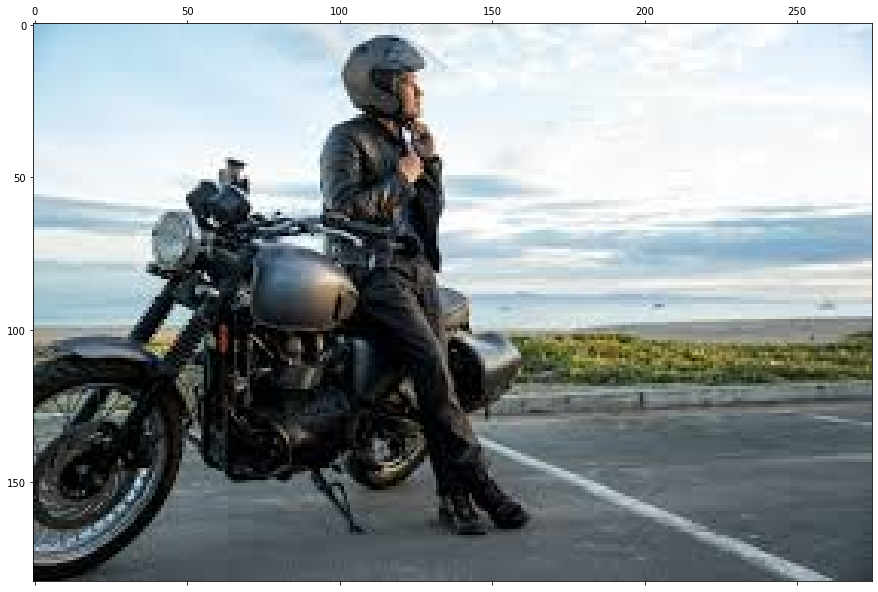

(183, 275, 3)
(1, 3, 416, 416)


In [138]:
img = cv2.imread("test4.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print("影像的維度大小：", img.shape)

import matplotlib.pyplot as plt
plt.matshow(img)
plt.show()

img = cv2.resize(img, None, fx=1, fy=1)
height, width, channels = img.shape
print(img.shape)

blob = cv2.dnn.blobFromImage(img, 1/255.0, (416,416), (0,0,0), True, crop=False)
print(blob.shape)

In [139]:
net.setInput(blob)
outs = net.forward(output_layers)

print("輸出的尺度數量：", len(outs))
print("輸出的標註框(bbox)的數量與長度：",outs[0].shape)

輸出的尺度數量： 2
輸出的標註框(bbox)的數量與長度： (507, 85)


In [140]:
import numpy as np

class_ids = []
confidences = []
boxes = []
    
for out in outs:
    for detection in out:
        tx, ty, tw, th, confidence = detection[0:5]
        scores = detection[5:]
        class_id = np.argmax(scores)  
        if confidence > 0.2:   
            center_x = int(tx * width)
            center_y = int(ty * height)
            w = int(tw * width)
            h = int(th * height)
            
            # 取得箱子方框座標
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)
            
print(len(class_ids))

2


In [150]:
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.2, 0.3)
print(len(indexes))
font = cv2.FONT_HERSHEY_TRIPLEX

from random import randint
colors = []
for i in range(80):
    colors.append((randint(0, 255),randint(0, 255),randint(0, 255)))

for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        color = colors[class_ids[i]]
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, label, (x, y - 5), font, 0.3, color, 1)

2


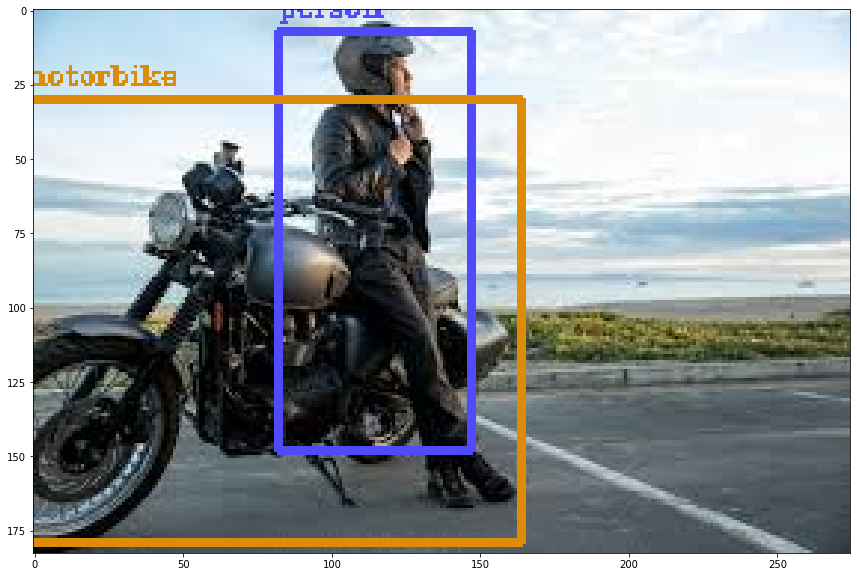

In [146]:
plt.imshow(img)

In [152]:
def yolo_detect(frame):
    img = cv2.resize(frame, None, fx=0.4, fy=0.4)
    height, width, channels = img.shape 
    
    blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), (0, 0, 0), True, crop=False)
    
    net.setInput(blob)
    outs = net.forward(output_layers)

    class_ids = []
    confidences = []
    boxes = []
    
    for out in outs:
        for detection in out:
            tx, ty, tw, th, confidence = detection[0:5]
            
            scores = detection[5:]
            class_id = np.argmax(scores)  
            if confidence > 0.5:   
                center_x = int(tx * width)
                center_y = int(ty * height)
                w = int(tw * width)
                h = int(th * height)

                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
                
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.3)
    
    font = cv2.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = colors[class_ids[i]]
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv2.putText(img, label, (x, y -5), font, 0.5, color, 1)
    return img

In [153]:
#VIDEO_IN = cv2.VideoCapture(0)
VIDEO_IN = cv2.VideoCapture("test.mp4") 

while True:
    hasFrame, frame = VIDEO_IN.read()
    
    img = yolo_detect(frame)
    cv2.imshow("Frame", img)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
VIDEO_IN.release()
cv2.destroyAllWindows()